In [1]:
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [2]:
class DataTransform():
    """
    画像とアノテーションの前処理クラス。訓練と推論で異なる動作をする。
    画像のサイズを300x300にする。
    学習時はデータオーギュメンテーションする。


    Attributes
    ----------
    input_size : int
        リサイズ先の画像の大きさ。
    color_mean : (B, G, R)
        各色チャネルの平均値。
    """

    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # intをfloat32に変換
                ToAbsoluteCoords(),  # アノテーションデータの規格化を戻す
                PhotometricDistort(),  # 画像の色調などをランダムに変化
                Expand(color_mean),  # 画像のキャンバスを広げる
                RandomSampleCrop(),  # 画像内の部分をランダムに抜き出す
                RandomMirror(),  # 画像を反転させる
                ToPercentCoords(),  # アノテーションデータを0-1に規格化
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ]),
            'val': Compose([
#                 ConvertFromInts(),  # intをfloatに変換
#                 Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
#                 SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ])
        }
        pass

    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img, boxes, labels)


In [16]:
class Anno_xml2list(object):
    """
    1枚の画像に対する「XML形式のアノテーションデータ」を、画像サイズで規格化してからリスト形式に変換する。

    Attributes
    ----------
    classes : リスト
        VOCのクラス名を格納したリスト
    """

    def __init__(self, classes):

        self.classes = classes

    def __call__(self, xml_path, width, height):
        """
        1枚の画像に対する「XML形式のアノテーションデータ」を、画像サイズで規格化してからリスト形式に変換する。

        Parameters
        ----------
        xml_path : str
            xmlファイルへのパス。
        width : int
            対象画像の幅。
        height : int
            対象画像の高さ。

        Returns
        -------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ... ]
            物体のアノテーションデータを格納したリスト。画像内に存在する物体数分のだけ要素を持つ。
        """

        # 画像内の全ての物体のアノテーションをこのリストに格納します
        ret = []

        # xmlファイルを読み込む
        xml = ET.parse(xml_path).getroot()
        

        # 画像内にある物体（object）の数だけループする
        for obj in xml.iter('object'):

            # アノテーションで検知がdifficultに設定されているものは除外
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue

            # 1つの物体に対するアノテーションを格納するリスト
            bndbox = []

            name = obj.find('name').text.lower().strip()  # 物体名
            bbox = obj.find('bndbox')  # バウンディングボックスの情報
            # アノテーションの xmin, ymin, xmax, ymaxを取得し、0～1に規格化
            pts = ['xmin', 'ymin', 'xmax', 'ymax']

            for pt in (pts):
                # VOCは原点が(1,1)なので1を引き算して（0, 0）に
                cur_pixel = int(bbox.find(pt).text) - 1
                
                # 幅、高さで規格化
                if pt == 'xmin' or pt == 'xmax':  # x方向のときは幅で割算
                    cur_pixel /= width
                else:  # y方向のときは高さで割算
                    cur_pixel /= height

                bndbox.append(cur_pixel)

            # アノテーションのクラス名のindexを取得して追加
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)

            # retに[xmin, ymin, xmax, ymax, label_ind]を足す
            ret += [bndbox]
        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ... ]


In [28]:
image_file_path = '2007_000068.jpg'
img = cv2.imread(image_file_path)

In [29]:
height, width, channels = img.shape

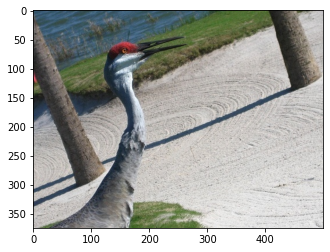

In [40]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [41]:
from data_augumentation import *

In [42]:
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

In [43]:
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno('2007_000068.xml', width, height)

In [44]:
anno_list

array([[0.052     , 0.11733333, 0.53      , 0.99733333, 2.        ]])

In [45]:
color_mean = (104, 117, 123)
input_size = 300
transform = DataTransform(input_size, color_mean)

In [46]:
phase = 'train'
img_transformed, boxes, labels = transform(img, phase, anno_list[:, :4], anno_list[:, 4])

In [47]:
boxes

array([[0.48329621, 0.        , 1.        , 1.        ]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


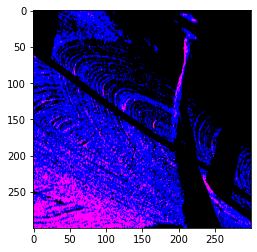

In [48]:
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))

In [49]:
img.max(), img.min(), img.mean()

(255, 0, 149.50248)

In [50]:
img_transformed.max(), img_transformed.min(), img_transformed.mean()

(45.089172, -135.53357, -34.770603)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


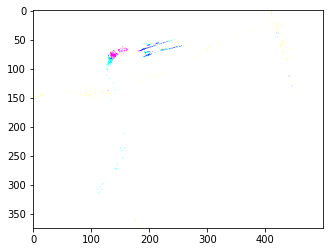

In [114]:
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


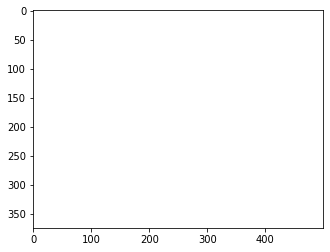

In [130]:
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


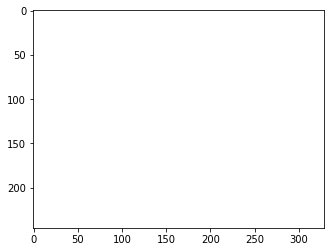

In [144]:
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


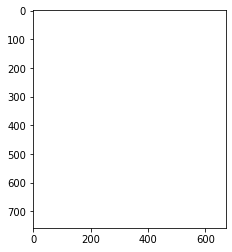

In [157]:
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


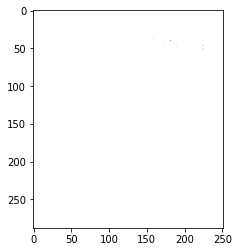

In [171]:
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


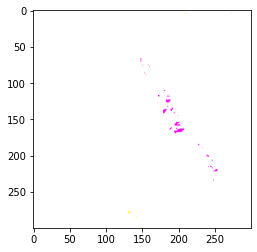

In [184]:
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


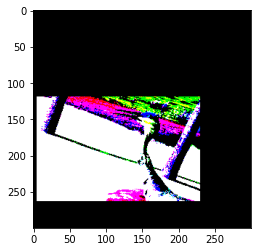

In [197]:
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))

In [199]:
img_transformed.max(), img_transformed.min(), img_transformed.mean()

(234.82117, -114.58108, 25.56809)